<a href="https://colab.research.google.com/github/Rotichkiprono/NeuralNetworks/blob/main/BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BINARY CLASSIFICATION**

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder #data scaling and one-hot encoding
from sklearn.impute import SimpleImputer #handling missing values
from sklearn.pipeline import make_pipeline #chaining preprocessing steps
from sklearn.compose import make_column_transformer # combining transformers for different data types

hotel = pd.read_csv('/content/hotel.csv')

X = hotel.copy() #avoid modifying the original data.
y = X.pop('is_canceled') #Separates the target variable

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    ) #Creates a new feature by converting arrival month names into numerical values

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
] #containing numerical features from the data like
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
] #containing categorical features

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
) #replaces missing values with a constant value using and scales the features
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
) #replaces missing values with a constant value and  encodes the categorical features using one-hot encoding

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
) #ensures each data type is preprocessed appropriately


X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)
    #Splits the data into training and validation sets & ensure the classes are evenly distributed across both sets

X_train = preprocessor.fit_transform(X_train)
#Fits the preprocessor on the training data it  learns the parameters for imputation and scaling
X_valid = preprocessor.transform(X_valid)
#Applies the already fitted preprocessor to transform the validation data

input_shape = [X_train.shape[1]]

# **creating the neural network**

In [ ]:
from tensorflow import keras #for build and train neural networks.
from tensorflow.keras import layers

model = keras.Sequential([ #stacks layers one after another
    layers.BatchNormalization(input_shape=input_shape), #helps to improve training stability and speed
    layers.Dense(256, activation='relu'), # has  256 neurons
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3), #randomly drops 30% of the activations from the previous layer,
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3), #prevents the model from overfitting
    layers.Dense(1,activation='sigmoid') #sigmoid activation function maps the output values to this range(0-1).

])

# **compiling the model**

In [ ]:
#specifies how the model will be trained and evaluated
model.compile(
    optimizer='adam', #adjusts the weights of the layers to minimize loss
    loss='binary_crossentropy', #measures how correct are the predictions
    metrics=['binary_accuracy'], #metrics the model will track during training
)


# **training the model**

Epoch 1/200
175/175 [==============================] - 7s 29ms/step - loss: 0.4782 - binary_accuracy: 0.7725 - val_loss: 0.4354 - val_binary_accuracy: 0.8070
Epoch 2/200
175/175 [==============================] - 3s 17ms/step - loss: 0.4215 - binary_accuracy: 0.8028 - val_loss: 0.4019 - val_binary_accuracy: 0.8139
Epoch 3/200
175/175 [==============================] - 3s 17ms/step - loss: 0.4093 - binary_accuracy: 0.8082 - val_loss: 0.3940 - val_binary_accuracy: 0.8164
Epoch 4/200
175/175 [==============================] - 3s 17ms/step - loss: 0.4011 - binary_accuracy: 0.8124 - val_loss: 0.3915 - val_binary_accuracy: 0.8180
Epoch 5/200
175/175 [==============================] - 4s 25ms/step - loss: 0.3964 - binary_accuracy: 0.8151 - val_loss: 0.3872 - val_binary_accuracy: 0.8217
Epoch 6/200
175/175 [==============================] - 3s 18ms/step - loss: 0.3920 - binary_accuracy: 0.8178 - val_loss: 0.3843 - val_binary_accuracy: 0.8220
Epoch 7/200
175/175 [==============================]

<Axes: title={'center': 'Accuracy'}>

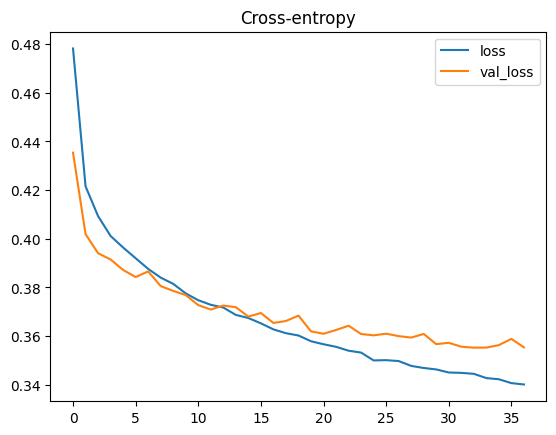

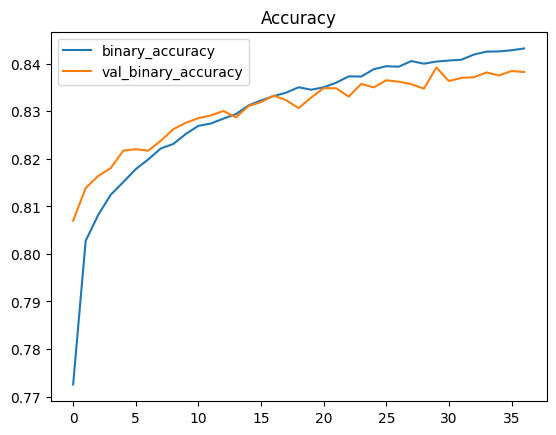

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5, #specifies the number of epochs with no improvement to wait before stopping training
    min_delta=0.001, #minimum threshold for considering an improvement in validation loss
    restore_best_weights=True, #instructs callback to restore the weights that achieved the best validation loss during training.
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid), #monitor the validation loss during training
    batch_size=512, #controls how many samples are processed at once
    epochs=200, #iterations over the training data
    callbacks=[early_stopping], #use this callback to monitor for early stopping conditions.
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")